# EDA and Cleaning

In the last notebook I have collected the data in this I will explolre the data and clean it.

---

In [133]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

In [134]:
# Get the data
reddit = pd.read_csv('../data/reddit.csv')

In [135]:
reddit.head()

,subreddit,selftext,title,created_utc
0,bioinformatics,This question has been dealt with before in th...,Differences between genome builds,1673302734
1,bioinformatics,"&amp;#x200B;\n\nCurious, anyone in need of a c...",Anyone need a solid Rust developer familiar wi...,1673291931
2,bioinformatics,NaN,We're wasting money by only supporting gzip fo...,1673287206
3,bioinformatics,I want to quickly check whether a particular g...,Any publicly available mapped human WGS datase...,1673284236
4,bioinformatics,I am currently working on the Gut microbiome a...,Pipeline for Gene Sequencing,1673280166


In [136]:
# Selftext is a bit obscure name, I want to change it to be more explicit 
reddit.rename(columns = {'selftext': 'post_body_text'}, inplace = True)
reddit.head()

,subreddit,post_body_text,title,created_utc
0,bioinformatics,This question has been dealt with before in th...,Differences between genome builds,1673302734
1,bioinformatics,"&amp;#x200B;\n\nCurious, anyone in need of a c...",Anyone need a solid Rust developer familiar wi...,1673291931
2,bioinformatics,NaN,We're wasting money by only supporting gzip fo...,1673287206
3,bioinformatics,I want to quickly check whether a particular g...,Any publicly available mapped human WGS datase...,1673284236
4,bioinformatics,I am currently working on the Gut microbiome a...,Pipeline for Gene Sequencing,1673280166


In [137]:
# Check for missing data
reddit.isnull().sum()

subreddit           0
post_body_text    399
title               0
created_utc         0
dtype: int64

In my subreddits the text of the post is missing in some cases, I will model on the title first and then add text and see if F1 score will improve. The created_utc was used for collecting the data and I do not need it for modeling

In [138]:
reddit.drop(columns = 'created_utc', inplace = True)

In [139]:
# Find the base line
reddit['subreddit'].value_counts(normalize=True)

datascience       0.672108
bioinformatics    0.327892
Name: subreddit, dtype: float64

My baseline is 67%

In [140]:
# Change titles to lower case
reddit['title'] = reddit['title'].str.lower()
reddit['post_body_text'] = reddit['post_body_text'].str.lower()

In [141]:
# Change the subreddit names to numbers for modeling
reddit['subreddit_num'] = reddit['subreddit'].map({'bioinformatics': 1, 'datascience ': 0})
reddit.head()

,subreddit,post_body_text,title,subreddit_num
0,bioinformatics,this question has been dealt with before in th...,differences between genome builds,1.0
1,bioinformatics,"&amp;#x200b;\n\ncurious, anyone in need of a c...",anyone need a solid rust developer familiar wi...,1.0
2,bioinformatics,NaN,we're wasting money by only supporting gzip fo...,1.0
3,bioinformatics,i want to quickly check whether a particular g...,any publicly available mapped human wgs datase...,1.0
4,bioinformatics,i am currently working on the gut microbiome a...,pipeline for gene sequencing,1.0


In [142]:
# Check the difference between title and self_text length for Bioinformatics and Data Science
reddit['title_length'] = reddit['title'].map(lambda x: len(x))
reddit['post_body_text_length'] = reddit['post_body_text'].map(lambda x: len(str(x)))
reddit.groupby('subreddit')[['title_length', 'post_body_text_length']].mean()

,title_length,post_body_text_length
subreddit,,
bioinformatics,58.361640,551.986823
datascience,59.399286,473.395714


The average Title length is about the same for Bioinformatics and Data Science, however, the average length of the body of the post is different, higher for bioinformatics.
I want to check if most of the missing texts are from Data Science.

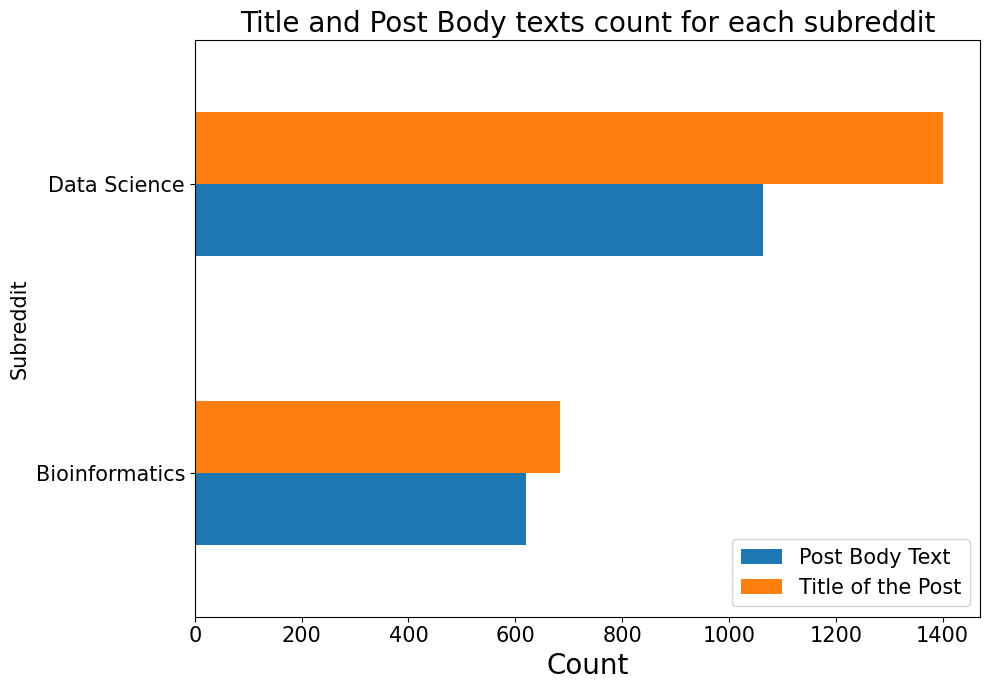

In [143]:
reddit.groupby('subreddit')[['post_body_text', 'title']].count().plot(kind='barh', figsize=(10, 7));
plt.title('Title and Post Body texts count for each subreddit', size = 20)
plt.xticks(size = 15)
plt.xlabel('Count', size = 20)
plt.yticks(np.arange(2), ['Bioinformatics', 'Data Science'], size = 15)
plt.ylabel('Subreddit', size = 15)
plt.legend(fontsize = 15, labels = ['Post Body Text', 'Title of the Post'])
plt.tight_layout()
plt.savefig('../images/title_post_body_counts.jpeg');

As I suspected Data Science has much more missing post body texts than Bioinformatics, it can influence the average length of the post.

In [144]:
# Check the difference between title word count for Bioinformatics and Data Science 
reddit['title_word_count'] = reddit['title'].map(lambda x: len(x.split()))
reddit.groupby('subreddit')['title_word_count'].mean()

subreddit
bioinformatics     9.229868
datascience       10.011429
Name: title_word_count, dtype: float64

The difference between average count of words per title is small.

---

I want to find the most common words in each subreddit

In [164]:
reddit_datascience = reddit[reddit['subreddit'] == 'datascience'].copy()
reddit_bioinformatics = reddit[reddit['subreddit'] == 'bioinformatics'].copy()

In [165]:
def count_most_common_words(df, column_to_vectirize, n_most_common):
    cvec = CountVectorizer(stop_words = 'english')
    cvec.fit(df[column_to_vectirize])
    vectorized_column = cvec.transform(df[column_to_vectirize])
    vectorized_df = pd.DataFrame(vectorized_column.todense(), columns = cvec.get_feature_names_out())
    return vectorized_df.sum().sort_values(ascending = False).head(n_most_common)

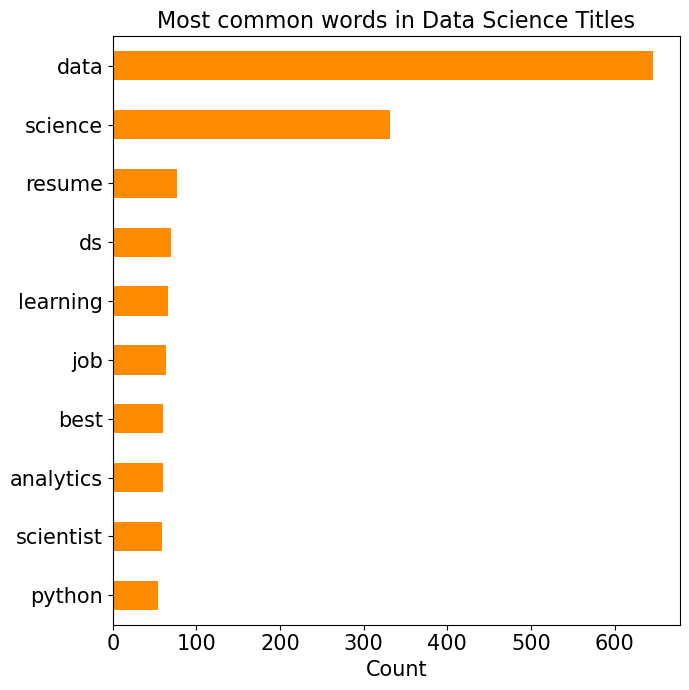

In [197]:
datascience_title_most_common = count_most_common_words(reddit_datascience, 'title', 10)
datascience_title_most_common[::-1].plot(kind = 'barh', figsize = (7, 7), color = 'darkorange')
plt.title('Most common words in Data Science Titles', size = 16)
plt.xticks(size = 15)
plt.xlabel('Count', size = 15)
plt.yticks(size = 15)
plt.tight_layout()
plt.savefig('../images/title_data_science_most_common_words.jpeg');

Data and Science are by far the most common words

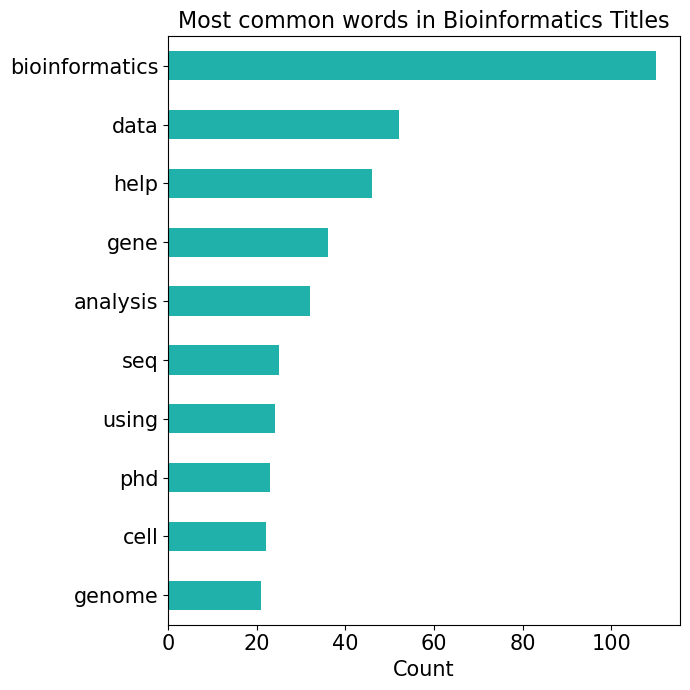

In [198]:
bioinformatics_title_most_common = count_most_common_words(reddit_bioinformatics, 'title', 10)
bioinformatics_title_most_common[::-1].plot(kind = 'barh', figsize = (7, 7), color = 'lightseagreen')
plt.title('Most common words in Bioinformatics Titles', size = 16)
plt.xticks(size = 15)
plt.xlabel('Count', size = 15)
plt.yticks(size = 15)
plt.tight_layout()
plt.savefig('../images/title_bioinformatics_most_common_words.jpeg');

The most common word by far is bioinformatics, the second is data. 

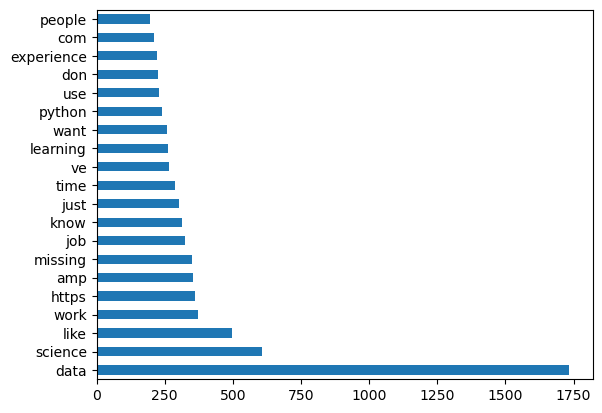

In [172]:
# To find most common words in Post Body Text I will impute all raws with missing data with 'missing'
reddit_datascience.fillna('missing', inplace = True)
datascience_post_body_text_most_common = count_most_common_words(reddit_datascience, 'post_body_text', 20)
datascience_post_body_text_most_common[::-1].plot(kind = 'barh');

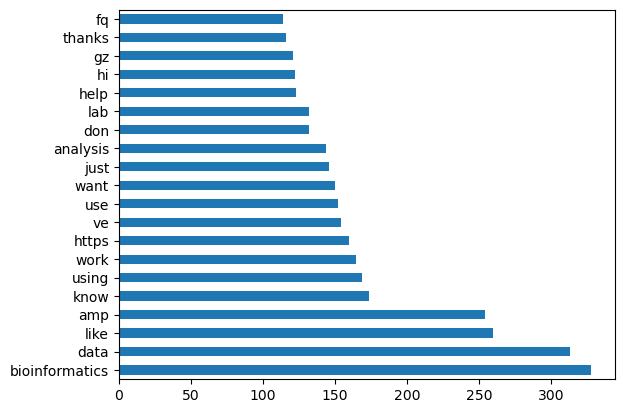

In [171]:
reddit_bioinformatics.fillna('missing', inplace = True)
bioinformatics_post_body_text_most_common = count_most_common_words(reddit_bioinformatics, 'post_body_text', 20)
bioinformatics_post_body_text_most_common[::-1].plot(kind = 'barh');